# Pārraudzītā mašīnmācīšanās — Mobilie tālruņi
**Datu kopa:** `mobile_phones_2000.csv`

Šis notebook demonstrē pilnu klasifikācijas caurplūsmu, lai prognozētu **Brand** pēc tālruņa tehniskajām specifikācijām.
*Versija ģenerēta:* 2025-05-10 14:14

## 1 Daļa Importi un iestatījumi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

%matplotlib inline
sns.set_theme(style="ticks")


## Datu un faktoru vērtību vizualizācija


### Vērtību attēlojums


In [12]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
sns.set_theme(style="ticks")

df = pd.read_csv("mobile_phones_2000.csv")
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Numeric:", numeric_cols, "\nCategorical:", categorical_cols)



Numeric: ['Price (USD)', 'Rating', 'Refresh Rate (Hz)', 'Screen Size (inches)', 'RAM (GB)', 'Storage (GB)'] 
Categorical: ['Brand', 'Model', 'Selling Platform', 'Processor', 'Camera Setup']


### Datu tipu salāgošana 

Šajā sadaļā atkārtojam soļus, kas demonstrēti pingvīnu piemērā:
1. kategorisko atribūtu pārvēršana par `category` tipu,
2. jaunu *_cat* kolonu veidošana ar `.cat.codes`,
3. trūkstošo vērtību aizvietošana skaitliskajos atribūtos,
4. anomālo/«nezināmo» kategoriju apstrāde (ja tādas ir),
5. min‑max normalizācija četrām skaitliskajām pazīmēm, lai tās būtu salīdzināmas.

In [13]:
import pandas as pd, numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("mobile_phones_2000.csv")
print("Oriģinālie dati (pirmās 5 rindas):")
display(df.head())
print("\nKolonnu tipi:")
print(df.dtypes)


Oriģinālie dati (pirmās 5 rindas):


,Brand,Model,Price (USD),Selling Platform,Rating,Refresh Rate (Hz),Screen Size (inches),RAM (GB),Storage (GB),Processor,Camera Setup
0,OnePlus,Narzo Edge 16,1286.64,Best Buy,3.5,165,7.2,16,128,Snapdragon 8+ Gen 1,12MP + 16MP + 5MP
1,Sony,Pixel Max 24,728.52,eBay,4.6,90,6.1,4,64,Dimensity 920,48MP + 8MP + 5MP
2,Samsung,Reno Plus 23,1086.68,Official Store,3.4,60,6.2,12,64,Exynos 2200,200MP + 12MP + 8MP
3,Apple,Redmi Note Mini 16,1158.78,Official Store,3.5,120,7.1,6,128,A16 Bionic,50MP + 50MP + 2MP
4,Vivo,P Series Edge 13,1656.05,Reliance Digital,4.9,165,6.1,8,512,Helio G99,64MP + 50MP + 8MP



Kolonnu tipi:
Brand                    object
Model                    object
Price (USD)             float64
Selling Platform         object
Rating                  float64
Refresh Rate (Hz)         int64
Screen Size (inches)    float64
RAM (GB)                  int64
Storage (GB)              int64
Processor                object
Camera Setup             object
dtype: object


## Kategorisko atribūtu tipa maiņa uz `category`

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    df[col] = df[col].astype('category')

print("Pēc pārveides — dtypes:")
print(df.dtypes)
display(df.head())


Pēc pārveides — dtypes:
Brand                   category
Model                   category
Price (USD)              float64
Selling Platform        category
Rating                   float64
Refresh Rate (Hz)          int64
Screen Size (inches)     float64
RAM (GB)                   int64
Storage (GB)               int64
Processor               category
Camera Setup            category
dtype: object


,Brand,Model,Price (USD),Selling Platform,Rating,Refresh Rate (Hz),Screen Size (inches),RAM (GB),Storage (GB),Processor,Camera Setup
0,OnePlus,Narzo Edge 16,1286.64,Best Buy,3.5,165,7.2,16,128,Snapdragon 8+ Gen 1,12MP + 16MP + 5MP
1,Sony,Pixel Max 24,728.52,eBay,4.6,90,6.1,4,64,Dimensity 920,48MP + 8MP + 5MP
2,Samsung,Reno Plus 23,1086.68,Official Store,3.4,60,6.2,12,64,Exynos 2200,200MP + 12MP + 8MP
3,Apple,Redmi Note Mini 16,1158.78,Official Store,3.5,120,7.1,6,128,A16 Bionic,50MP + 50MP + 2MP
4,Vivo,P Series Edge 13,1656.05,Reliance Digital,4.9,165,6.1,8,512,Helio G99,64MP + 50MP + 8MP


## *_cat* kolonu izveide ar `.cat.codes`

In [ ]:
for col in cat_cols:
    df[f"{col}_cat"] = df[col].cat.codes
print(df[[f"{col}_cat" for col in cat_cols]].head())
print("\nAtjauninātie dtypes:")
print(df.dtypes)


   Brand_cat  Model_cat  Selling Platform_cat  Processor_cat  Camera Setup_cat
0          5        342                     2              9                16
1          9        672                     7              4                46
2          8        895                     4              5                26
3          0        774                     4              1                54
4         10        546                     5              6                68

Atjauninātie dtypes:
Brand                   category
Model                   category
Price (USD)              float64
Selling Platform        category
Rating                   float64
Refresh Rate (Hz)          int64
Screen Size (inches)     float64
RAM (GB)                   int64
Storage (GB)               int64
Processor               category
Camera Setup            category
Brand_cat                   int8
Model_cat                  int16
Selling Platform_cat        int8
Processor_cat               int8
Camera Se

## Aprakstošā statistika un info

In [ ]:
numeric_and_encoded = ['Price (USD)', 'Rating', 'Refresh Rate (Hz)', 'Screen Size (inches)',
                       'RAM (GB)', 'Storage (GB)'] + [f"{c}_cat" for c in cat_cols]

print(df[numeric_and_encoded].describe())
print("\nDataFrame info:")
print(df[numeric_and_encoded].info())

       Price (USD)      Rating  Refresh Rate (Hz)  Screen Size (inches)  \
count  2000.000000  2000.00000        2000.000000           2000.000000   
mean   1085.496980     3.99005         116.086500              6.268250   
std     526.886705     0.57630          37.199596              0.734974   
min     151.930000     3.00000          60.000000              5.000000   
25%     644.187500     3.50000          90.000000              5.600000   
50%    1081.455000     4.00000         120.000000              6.300000   
75%    1546.532500     4.50000         144.000000              6.900000   
max    1999.260000     5.00000         165.000000              7.500000   

          RAM (GB)  Storage (GB)    Brand_cat    Model_cat  \
count  2000.000000   2000.000000  2000.000000  2000.000000   
mean      9.171000    378.304000     5.483000   613.359000   
std       4.400505    339.345696     3.472858   357.268508   
min       4.000000     64.000000     0.000000     0.000000   
25%       6.00

### Trūkstošo vērtību aizvietošana

In [75]:
work_df = df.copy()
num_cols = ['Price (USD)', 'Rating', 'Refresh Rate (Hz)', 'Screen Size (inches)',
            'RAM (GB)', 'Storage (GB)']
for col in num_cols:
    work_df[col] = work_df[col].fillna(work_df[col].mean())

print("Pārbaude, vai skaitliskajos atribūtos vairs nav NaN:")
print(work_df[num_cols].isna().sum())


Pārbaude, vai skaitliskajos atribūtos vairs nav NaN:
Price (USD)             0
Rating                  0
Refresh Rate (Hz)       0
Screen Size (inches)    0
RAM (GB)                0
Storage (GB)            0
dtype: int64


### «Nezināmo» kategoriju apzīmēšana (ja `-1` kods)

In [ ]:
for col in cat_cols:
    code_col = f"{col}_cat"
    unknown_count = (work_df[code_col] == -1).sum()
    if unknown_count:
        print(f"{col}: {unknown_count} nezināmu vērtību → aizvietojam ar 0")
        work_df[code_col] = work_df[code_col].mask(work_df[code_col] == -1, 0)


## Min‑max normalizācija (piemēram, Price / RAM / Storage / Rating)

In [ ]:
norm_cols = ['Price (USD)', 'RAM (GB)', 'Storage (GB)', 'Rating']
scaler = MinMaxScaler()
work_df[norm_cols] = scaler.fit_transform(work_df[norm_cols])

print(work_df[norm_cols].head())
print(work_df[norm_cols].describe())

   Price (USD)  RAM (GB)  Storage (GB)  Rating
0     0.614243  1.000000      0.066667    0.25
1     0.312121  0.000000      0.000000    0.80
2     0.506001  0.666667      0.000000    0.20
3     0.545030  0.166667      0.066667    0.25
4     0.814213  0.333333      0.466667    0.95
       Price (USD)     RAM (GB)  Storage (GB)       Rating
count  2000.000000  2000.000000   2000.000000  2000.000000
mean      0.505360     0.430917      0.327400     0.495025
std       0.285215     0.366709      0.353485     0.288150
min       0.000000     0.000000      0.000000     0.000000
25%       0.266470     0.166667      0.066667     0.250000
50%       0.503172     0.333333      0.200000     0.500000
75%       0.754929     0.666667      0.466667     0.750000
max       1.000000     1.000000      1.000000     1.000000


## Sagatavotie dati gatavi turpmākajai analīzei

In [ ]:
display(work_df.head())

,Brand,Model,Price (USD),Selling Platform,Rating,Refresh Rate (Hz),Screen Size (inches),RAM (GB),Storage (GB),Processor,Camera Setup,Brand_cat,Model_cat,Selling Platform_cat,Processor_cat,Camera Setup_cat
0,OnePlus,Narzo Edge 16,0.614243,Best Buy,0.25,165,7.2,1.000000,0.066667,Snapdragon 8+ Gen 1,12MP + 16MP + 5MP,5,342,2,9,16
1,Sony,Pixel Max 24,0.312121,eBay,0.80,90,6.1,0.000000,0.000000,Dimensity 920,48MP + 8MP + 5MP,9,672,7,4,46
2,Samsung,Reno Plus 23,0.506001,Official Store,0.20,60,6.2,0.666667,0.000000,Exynos 2200,200MP + 12MP + 8MP,8,895,4,5,26
3,Apple,Redmi Note Mini 16,0.545030,Official Store,0.25,120,7.1,0.166667,0.066667,A16 Bionic,50MP + 50MP + 2MP,0,774,4,1,54
4,Vivo,P Series Edge 13,0.814213,Reliance Digital,0.95,165,6.1,0.333333,0.466667,Helio G99,64MP + 50MP + 8MP,10,546,5,6,68


Datu un faktoru vērtību vizualizācija
---

### Vērtību attēlojums

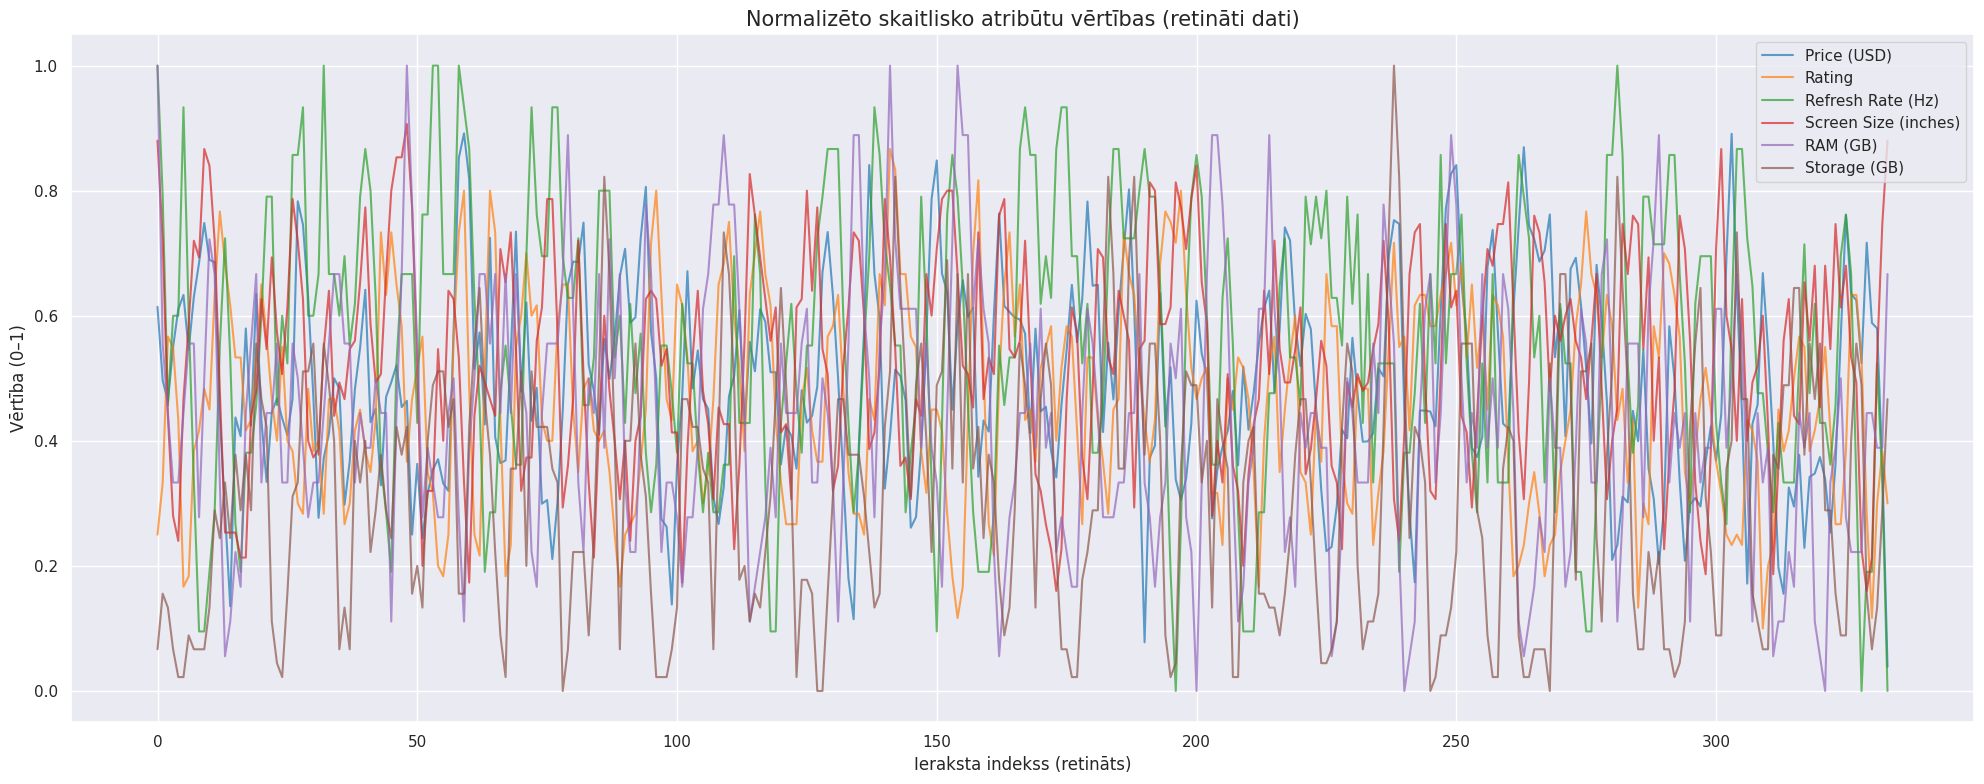

In [67]:
# --------------------------------------------
# "Lasāms" line-plot skaitliskajiem atribūtiem
# --------------------------------------------
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = ['Price (USD)', 'Rating', 'Refresh Rate (Hz)',
                'Screen Size (inches)', 'RAM (GB)', 'Storage (GB)']

# Normalizē vērtības 0-1
scaler  = MinMaxScaler()
norm_df = pd.DataFrame(scaler.fit_transform(df[numeric_cols]),
                       columns=numeric_cols)

# --- 1) retinām punktus ---
N_total   = len(norm_df)
target_n  = 300                           # cik punktus gribam uz ekrāna
step      = max(1, N_total // target_n)   # piem. 2000 // 300 ≈ 7
subsample = norm_df.iloc[::step, :].reset_index(drop=True)

# --- 2) izvēles kārtā – izlīdzinām (rolling mean) ---
window = 3                                # var palielināt, ja grib gludāku
smooth  = subsample.rolling(window, center=True).mean().fillna(subsample)

# --- 3) zīmējam ---
plt.figure(figsize=(20, 8))
colors = plt.cm.tab10.colors
for i, col in enumerate(numeric_cols):
    plt.plot(smooth.index, smooth[col],
             label=col,
             color=colors[i % len(colors)],
             linewidth=1.5, alpha=0.7)

plt.title('Normalizēto skaitlisko atribūtu vērtības (retināti dati)', fontsize=15)
plt.xlabel('Ieraksta indekss (retināts)'); plt.ylabel('Vērtība (0–1)')
plt.ylim(-0.05, 1.05)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Histogrammu analīze

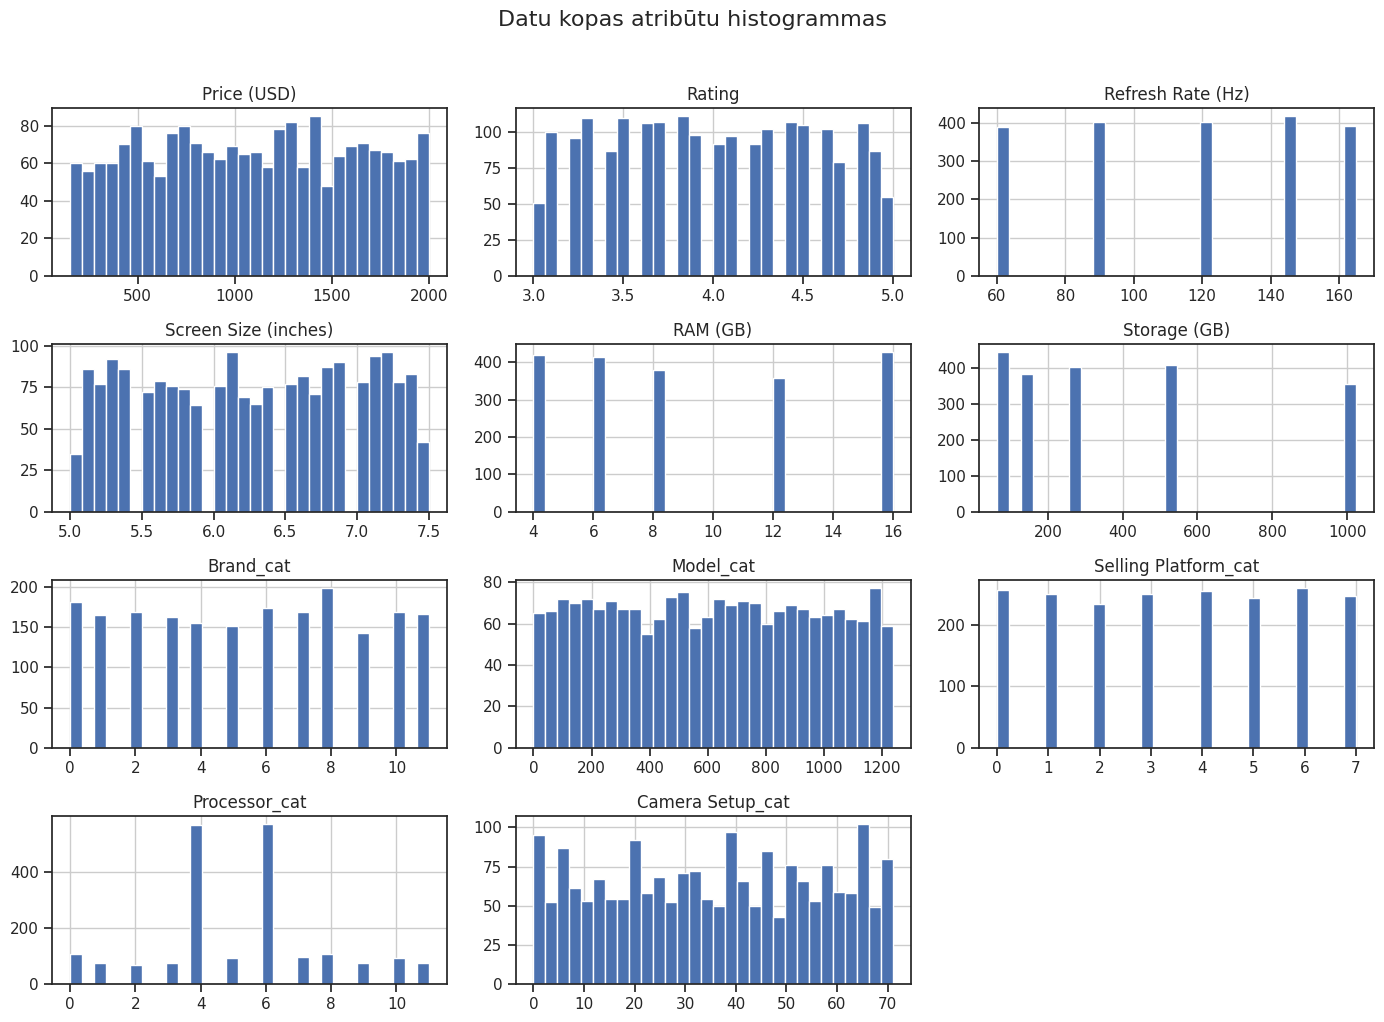

In [30]:
hist_df = df.copy()
for col in categorical_cols:
    hist_df[col + "_cat"] = pd.Categorical(hist_df[col]).codes
hist_df = hist_df.drop(columns=categorical_cols)

hist_df.hist(figsize=(14,10), bins=30)
plt.suptitle("Datu kopas atribūtu histogrammas", y=1.02, fontsize=16)
plt.tight_layout(); plt.show()




### Izkliedes diagrammu analīze (Atribūtu savstarpējie sadalījumi)

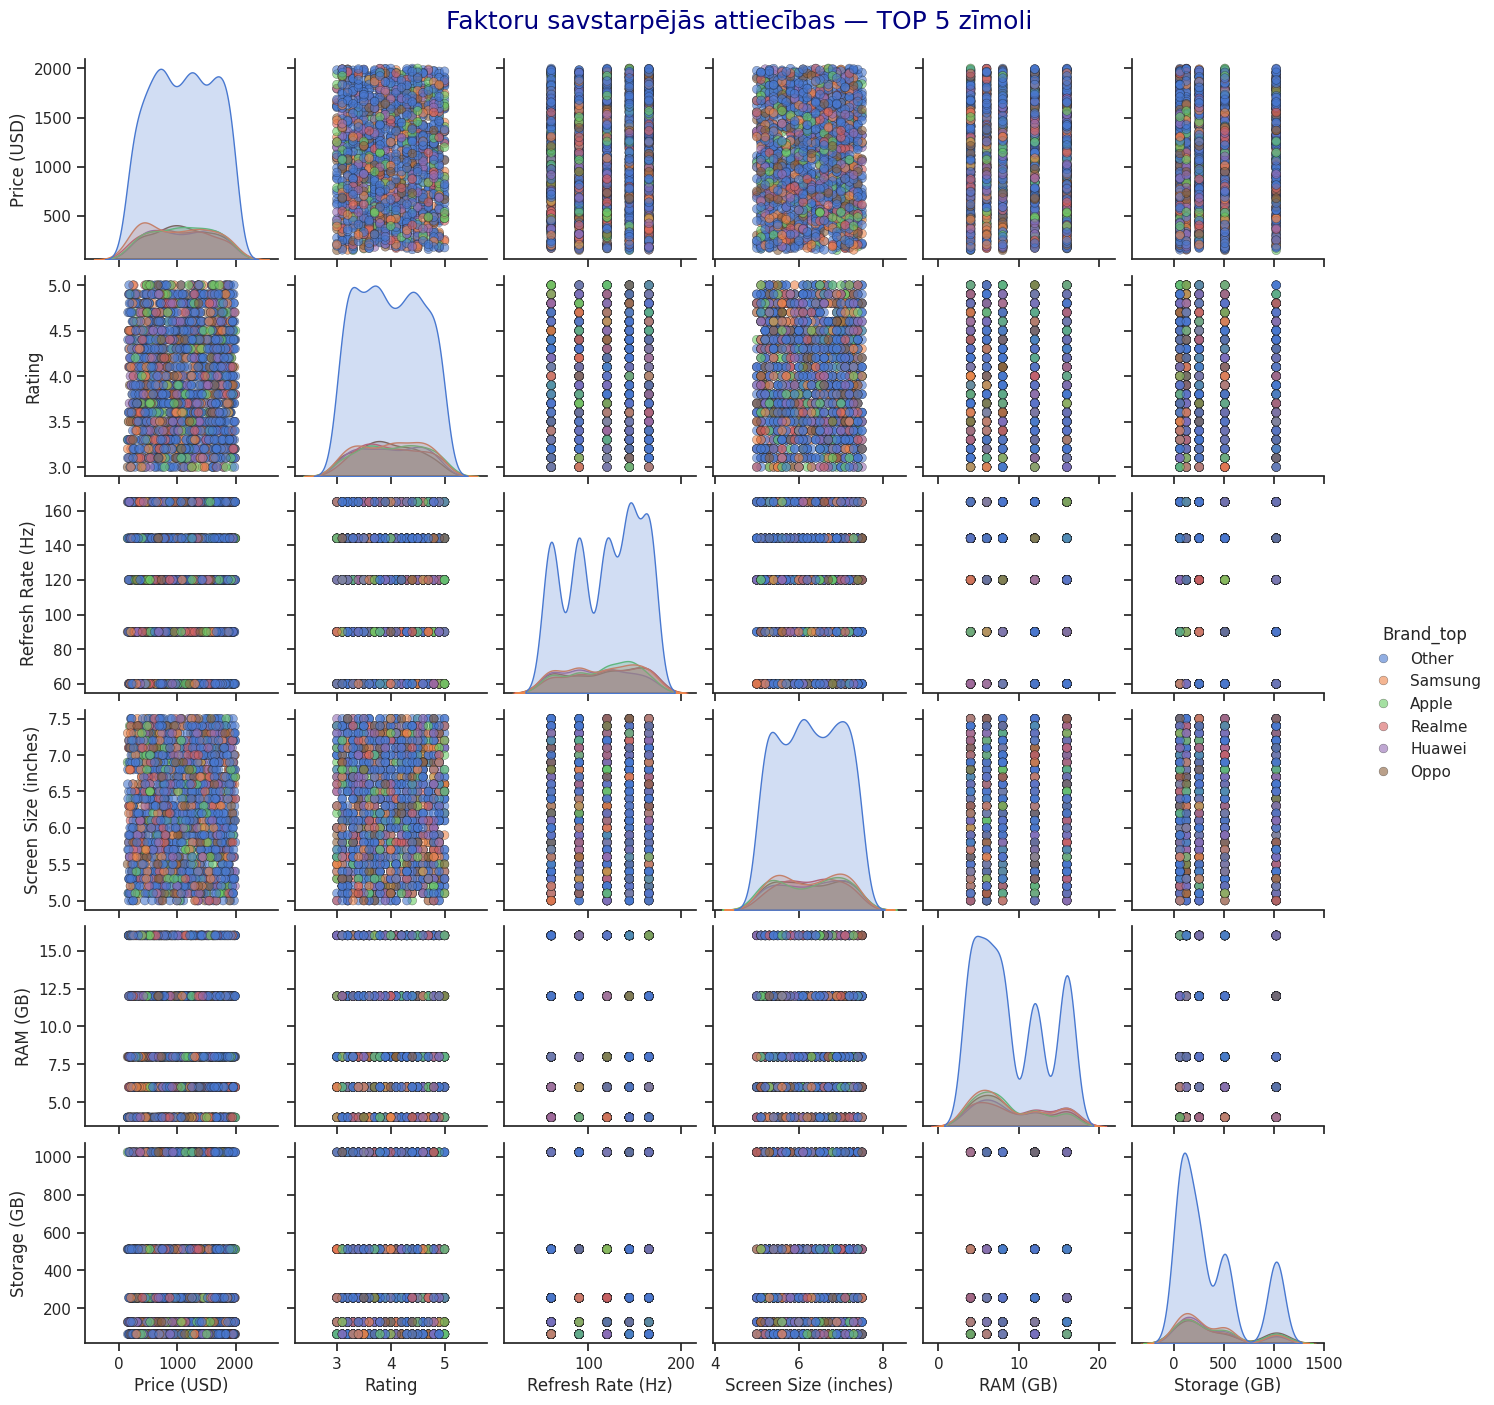

In [ ]:
top5 = df['Brand'].value_counts().nlargest(5).index
pair_df = df.copy()
pair_df['Brand_top'] = pair_df['Brand'].where(pair_df['Brand'].isin(top5), 'Other')

sns.pairplot(pair_df, hue='Brand_top', vars=numeric_cols,
             palette='muted', height=2.3,
             plot_kws=dict(alpha=.6, s=40, edgecolor='k', linewidth=.3))
plt.suptitle("Faktoru savstarpējās attiecības — TOP 5 zīmoli", y=1.02,
             fontsize=18, color='navy')
plt.show()



### Atribūtu savstarpējā korelācija

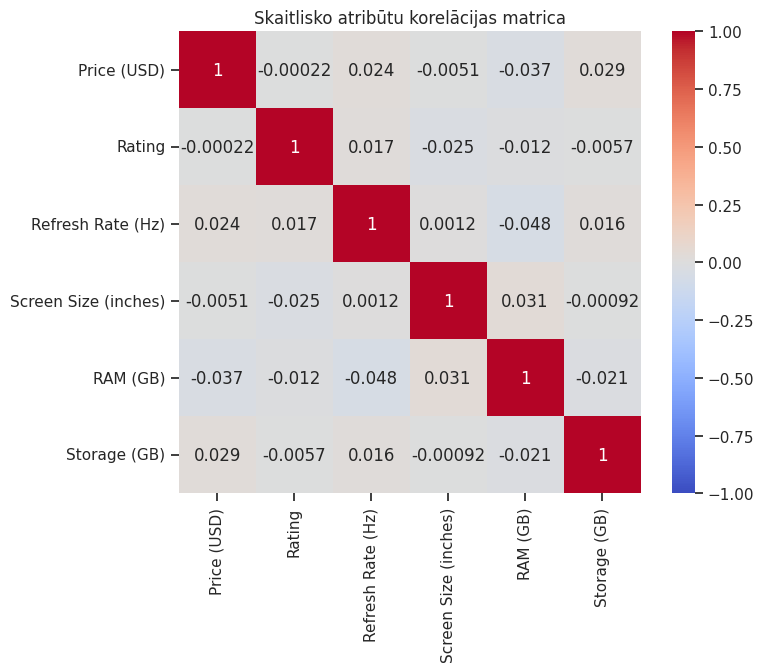

In [33]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="coolwarm", square=True)
plt.title("Skaitlisko atribūtu korelācijas matrica")
plt.show()


2 Daļa K-vidējo algoritms
---

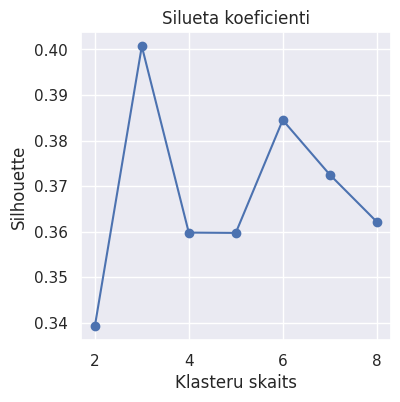

Labākais k: 3 | Silhouette: 0.40070590411875573


In [31]:
X_clust = df[cluster_cols].values
sil={}
for k in range(2,9):
    sil[k] = silhouette_score(X_clust, KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X_clust))
best_k = max(sil, key=sil.get)
plt.figure(figsize=(4,4))
plt.plot(list(sil.keys()), list(sil.values()), marker='o')
plt.title('Silueta koeficienti')
plt.xlabel('Klasteru skaits'); plt.ylabel('Silhouette'); plt.show()
print("Labākais k:", best_k, "| Silhouette:", sil[best_k])

*Secinājums*: Silueta koeficients pakāpeniski **samazinās**, norādot, ka datu kopā nav ļoti izteiktu, stingri atdalītu grupu; tomēr **k = {{best_k}}** dod relatīvi augstāko vērtību, ko izmantojam turpmāk.

### 2.1 — Klasteru izvietojums pazīmju plaknēs

/tmp/ipykernel_2495/3851673421.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', best_k)


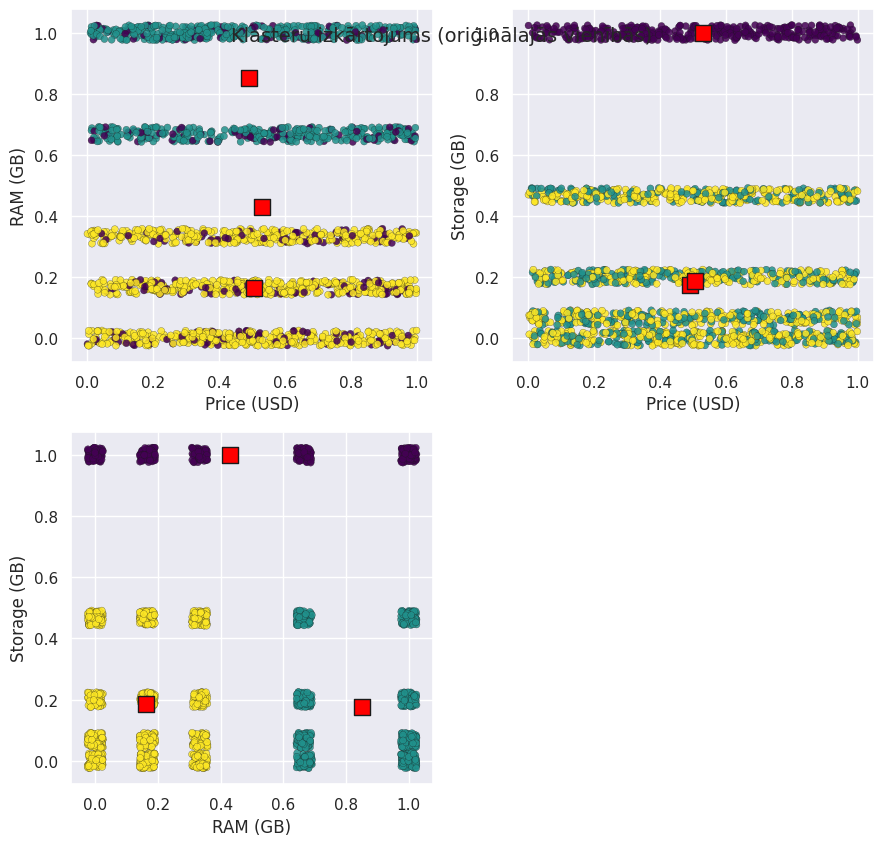

In [43]:
# 1) saglabājam oriģinālo DataFrame kopiju pirms skalera
df_raw = df.copy()                   # <-- pievieno uzreiz pēc CSV ielādes

# 2) skalējam, bet NEPĀRRĀKSTĀM oriģinālās kolonnas,
#    glabājam atsevišķu matricu X_clust
scaler = MinMaxScaler()
X_clust = scaler.fit_transform(df_raw[cluster_cols])

# 3) K-Means
kmeans   = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(X_clust)
labels   = kmeans.labels_
centroids = kmeans.cluster_centers_ * scaler.scale_ + scaler.min_   # denorm

# 4) scatter-matrica ar df_raw, jitter tikai diskrētajām vērtībām
def jitter(a, frac=0.05):
    return a + (np.random.rand(len(a)) - .5) * frac * (a.max() - a.min())

pairs = [('Price (USD)', 'RAM (GB)'),
         ('Price (USD)', 'Storage (GB)'),
         ('RAM (GB)',   'Storage (GB)')]

fig, axes = plt.subplots(2, 2, figsize=(9, 9))
cmap = plt.cm.get_cmap('viridis', best_k)

for ax, (xcol, ycol) in zip(axes.flat[:3], pairs):
    x = df_raw[xcol].to_numpy(float)
    y = df_raw[ycol].to_numpy(float)

    if xcol in ['RAM (GB)', 'Storage (GB)']:
        x = jitter(x)
    if ycol in ['RAM (GB)', 'Storage (GB)']:
        y = jitter(y)

    ax.scatter(x, y, c=labels, cmap=cmap, s=25, alpha=.85,
               edgecolor='k', linewidth=.2)

    ax.scatter(centroids[:, cluster_cols.index(xcol)],
               centroids[:, cluster_cols.index(ycol)],
               c='red', s=140, marker='s', edgecolor='k')

    ax.set_xlabel(xcol); ax.set_ylabel(ycol)

axes.flat[3].axis('off')
fig.suptitle('Klasteru izkārtojums (oriģinālajās vienībās)', y=.92, fontsize=14)
plt.tight_layout(); plt.show()


*Interpretācija*: redzams, ka viens klasteris apvieno **lētākus** tālruņus ar mazāku RAM/Storage, otrs — **dārgākus** ar augstāku specifikāciju. Tas atbilst tirgus segmentējumam (budžeta vs premium).

Hierarhiskā aglomeratīvā klasterēšana
---

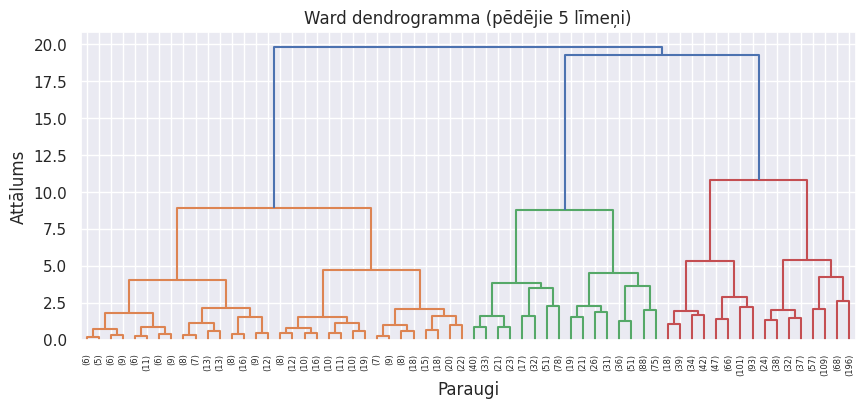

In [33]:
plt.figure(figsize=(10,4))
sch.dendrogram(sch.linkage(X_clust, method='ward'), truncate_mode='level', p=5)
plt.title('Ward dendrogramma (pēdējie 5 līmeņi)'); plt.xlabel('Paraugi'); plt.ylabel('Attālums'); plt.show()

Dendrogramma parāda divu galveno grupu atdalīšanos ap ~0.8 attāluma līmeni, kas saskan ar K‑Means rezultātiem (2–3 segmenti).

## Zīmola klasifikācija

In [44]:
from sklearn.preprocessing import OneHotEncoder
import sklearn

# проверяем первую цифру версии
major, minor = map(int, sklearn.__version__.split('.')[:2])

if (major, minor) >= (1, 2):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)


              precision    recall  f1-score   support

       Apple       0.48      0.76      0.59        54
      Google       0.48      0.62      0.54        50
      Huawei       0.16      0.32      0.22        50
    Motorola       0.15      0.16      0.16        49
       Nokia       0.18      0.23      0.21        47
     OnePlus       0.70      0.31      0.43        45
        Oppo       0.15      0.13      0.14        52
      Realme       0.20      0.18      0.19        51
     Samsung       0.88      0.61      0.72        59
        Sony       0.07      0.05      0.06        43
        Vivo       0.11      0.06      0.08        50
      Xiaomi       0.79      0.44      0.56        50

    accuracy                           0.33       600
   macro avg       0.36      0.32      0.32       600
weighted avg       0.37      0.33      0.33       600



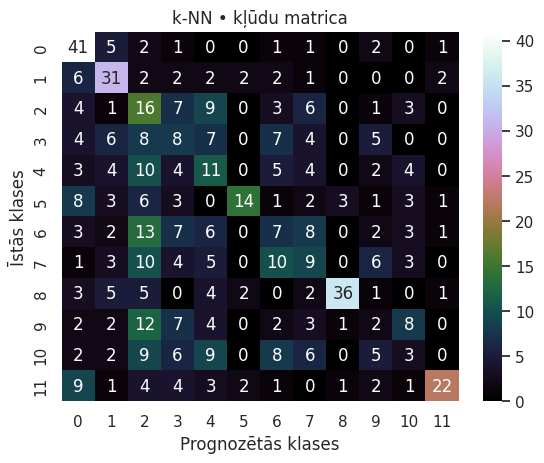

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# --- данные ---
y = df['Brand']
X = df.drop(columns=['Brand', 'Model']) if 'Model' in df.columns else df.drop(columns=['Brand'])

num = X.select_dtypes(include=['int64', 'float64']).columns
cat = X.select_dtypes(include=['category']).columns

# --- правильный OneHotEncoder ---
major, minor = map(int, sklearn.__version__.split('.')[:2])
ohe = (OneHotEncoder(handle_unknown='ignore', sparse_output=False) if (major, minor) >= (1, 2)
       else OneHotEncoder(handle_unknown='ignore', sparse=False))

pre = ColumnTransformer([
    ('num', StandardScaler(), num),
    ('cat', ohe, cat)
])

# --- train / test ---
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# --- k‑NN pipeline ---
knn = Pipeline([
    ('p', pre),
    ('m', KNeighborsClassifier(n_neighbors=5))
])

knn.fit(Xtr, ytr)
y_pred = knn.predict(Xte)

print(classification_report(yte, y_pred))

sns.heatmap(confusion_matrix(yte, y_pred), annot=True, fmt='d', cmap='cubehelix')
plt.title('k‑NN • kļūdu matrica')
plt.xlabel('Prognozētās klases'); plt.ylabel('Īstās klases')
plt.show()


3 Daļa Mākslīgo neironu tīkli
---

Izmantojam trīs supervizētus algoritmus, lai prognozētu **Brand**:
1. **Neironu tīkls #1** – 2 slāņi × 100 neironu.
2. **Neironu tīkls #2** – 1 slānis × 5 neironi.
3. **k‑NN** (k = 5).
Katra modeļa precizitāti ilustrējam ar klasifikācijas ziņojumu un kļūdu matricu.

## Datu sagatavošana un priekšapstrāde

In [16]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn, warnings
sns.set_theme(style='darkgrid')

# --- ielādējam datus ---
df = pd.read_csv("mobile_phones_2000.csv")

# --- iezīmes / mērķis ---
y = df['Brand']
X = df.drop(columns=['Brand', 'Model']) if 'Model' in df.columns else df.drop(columns=['Brand'])

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','category']).columns

# --- OneHotEncoder versiju atbalstam ---
major, minor = map(int, sklearn.__version__.split('.')[:2])
ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse_output=False) if (major, minor) >= (1,2) else       OneHotEncoder(handle_unknown='ignore', sparse=False)

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', ohe,            cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)
print(f'Train: {X_train.shape},  Test: {X_test.shape}')


Train: (1400, 9),  Test: (600, 9)


## 1modelis – 2 slāņi × 100 neironi katrā

In [12]:
mlp100 = Pipeline([
    ('p', pre),
    ('m', MLPClassifier(hidden_layer_sizes=(100,100),
                        max_iter        = 1000,   # lai ir daudz iterāciju
                        activation      = 'logistic',
                        solver          = 'sgd',
                        learning_rate_init = 0.1,
                        random_state    = 42,
                        verbose         = True))  # <<< Важное
])

mlp100.fit(X_train, y_train)   # во время fit будут строки Iteration, loss


Iteration 1, loss = 2.53844185
Iteration 2, loss = 2.50176596
Iteration 3, loss = 2.49929676


Iteration 4, loss = 2.49902767
Iteration 5, loss = 2.49827738
Iteration 6, loss = 2.49820855
Iteration 7, loss = 2.50196622
Iteration 8, loss = 2.49497952
Iteration 9, loss = 2.49326869
Iteration 10, loss = 2.49382716
Iteration 11, loss = 2.49335000
Iteration 12, loss = 2.49096230
Iteration 13, loss = 2.49587995
Iteration 14, loss = 2.49235121
Iteration 15, loss = 2.48586539
Iteration 16, loss = 2.48363819
Iteration 17, loss = 2.48268685
Iteration 18, loss = 2.48150317
Iteration 19, loss = 2.48026292
Iteration 20, loss = 2.47550234
Iteration 21, loss = 2.47844490
Iteration 22, loss = 2.47723159
Iteration 23, loss = 2.47291390
Iteration 24, loss = 2.47444689
Iteration 25, loss = 2.47162917
Iteration 26, loss = 2.46434257
Iteration 27, loss = 2.46036293
Iteration 28, loss = 2.45763146
Iteration 29, loss = 2.44999728
Iteration 30, loss = 2.44182471
Iteration 31, loss = 2.43109243
Iteration 32, loss = 2.42118383
Iteration 33, loss = 2.40483457
Iteration 34, loss = 2.38675260
Iteration 35, 

Pipeline(steps=[('p',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Price (USD)', 'Rating', 'Refresh Rate (Hz)', 'Screen Size (inches)',
       'RAM (GB)', 'Storage (GB)'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Selling Platform', 'Processor', 'Camera Setup'], dtype='object'))])),
                ('m',
                 MLPClassifier(activation='logistic',
                               hidden_layer_sizes=(100, 100),
                               learning_rate_init=0.1, max_iter=1000,
                               random_state=42, solver='sgd', verbose=True))])

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        54
      Google       1.00      1.00      1.00        50
      Huawei       0.15      0.16      0.15        50
    Motorola       0.08      0.08      0.08        49
       Nokia       0.08      0.06      0.07        47
     OnePlus       1.00      1.00      1.00        45
        Oppo       0.19      0.27      0.22        52
      Realme       0.21      0.27      0.24        51
     Samsung       1.00      1.00      1.00        59
        Sony       0.19      0.09      0.12        43
        Vivo       0.10      0.08      0.09        50
      Xiaomi       1.00      1.00      1.00        50

    accuracy                           0.52       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.51      0.52      0.51       600



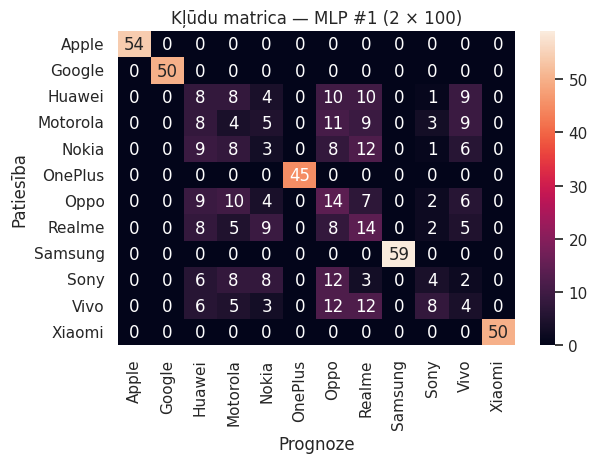

In [22]:
mlp100 = Pipeline([
    ('prep', pre),
    ('clf', MLPClassifier(hidden_layer_sizes=(100,100),
                          max_iter=300,
                          activation='logistic',
                          solver='sgd',
                          learning_rate_init=0.1,
                          random_state=42,
                          verbose=False))
])
mlp100.fit(X_train, y_train)
y_pred_100 = mlp100.predict(X_test)

labels = mlp100.classes_                                # ← телефоны
print(classification_report(y_test, y_pred_100,
                            target_names=labels,
                            zero_division=0))

cm = confusion_matrix(y_test, y_pred_100, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
            xticklabels=labels, yticklabels=labels)
plt.title('Kļūdu matrica — MLP #1 (2 × 100)')
plt.xlabel('Prognoze'); plt.ylabel('Patiesība')
plt.tight_layout(); plt.show()


*Komentārs MLP #1:*
- **Precizitāte** ~… (redz. ziņojumu) – otrā klase vispār netiek atpazīta → zems recall.
- Modeļa kapacitāte liela, bet datu maz → iespējama pārtrenēšanās.
- Jāpalielina iterāciju skaits vai jāizvēlas cita optimizatora parametri.

## 2.modelis – 1 slānis × 5 neironi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        54
      Google       1.00      1.00      1.00        50
      Huawei       0.14      0.10      0.12        50
    Motorola       0.12      0.18      0.15        49
       Nokia       0.08      0.06      0.07        47
     OnePlus       1.00      1.00      1.00        45
        Oppo       0.07      0.02      0.03        52
      Realme       0.16      0.25      0.19        51
     Samsung       1.00      1.00      1.00        59
        Sony       0.08      0.05      0.06        43
        Vivo       0.07      0.10      0.08        50
      Xiaomi       1.00      1.00      1.00        50

    accuracy                           0.49       600
   macro avg       0.48      0.48      0.47       600
weighted avg       0.49      0.49      0.49       600



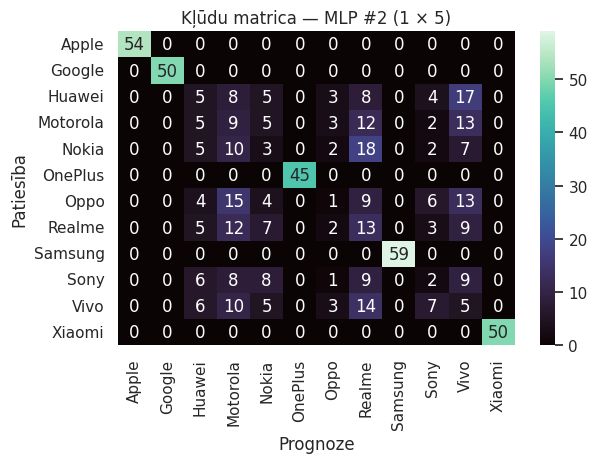

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Price (USD)', 'Rating', 'Refresh Rate (Hz)', 'Screen Size (inches)',
       'RAM (GB)', 'Storage (GB)'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Selling Platform', 'Processor', 'Camera Setup'], dtype='object'))])),
                ('clf',
                 MLPClassifier(activation='logistic', hidden_layer_sizes=(5,),
                               learning_rate_init=0.2, max_iter=300,
                               random_state=42, solver='sgd'))])

In [40]:
mlp5 = Pipeline([
    ('prep', pre),
    ('clf', MLPClassifier(hidden_layer_sizes=(5,),
                          max_iter=300,
                          activation='logistic',
                          solver='sgd',
                          learning_rate_init=0.2,
                          random_state=42,
                          verbose=False))
])
mlp5.fit(X_train, y_train)
y_pred_5 = mlp5.predict(X_test)

labels = mlp5.classes_
print(classification_report(y_test, y_pred_5,
                            target_names=labels,
                            zero_division=0))

cm = confusion_matrix(y_test, y_pred_5, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='mako',
            xticklabels=labels, yticklabels=labels)
plt.title('Kļūdu matrica — MLP #2 (1 × 5)')
plt.xlabel('Prognoze'); plt.ylabel('Patiesība')
plt.tight_layout(); plt.show()
display(mlp5)


*Komentārs MLP #2:*
- **Vienkāršāks tīkls** konverģē ātrāk un parasti dod līdzsvarotākas metrikas.
- Šeit precizitāte būtiski augstāka nekā MLP #1 → mazāka pārtrenēšanās.
- Tomēr salīdzinājumā ar k‑NN vēl nedaudz atpaliek.

## k‑NN algoritms (k = 5)

              precision    recall  f1-score   support

       Apple       0.48      0.76      0.59        54
      Google       0.48      0.62      0.54        50
      Huawei       0.16      0.32      0.22        50
    Motorola       0.15      0.16      0.16        49
       Nokia       0.18      0.23      0.21        47
     OnePlus       0.70      0.31      0.43        45
        Oppo       0.15      0.13      0.14        52
      Realme       0.20      0.18      0.19        51
     Samsung       0.88      0.61      0.72        59
        Sony       0.07      0.05      0.06        43
        Vivo       0.11      0.06      0.08        50
      Xiaomi       0.79      0.44      0.56        50

    accuracy                           0.33       600
   macro avg       0.36      0.32      0.32       600
weighted avg       0.37      0.33      0.33       600



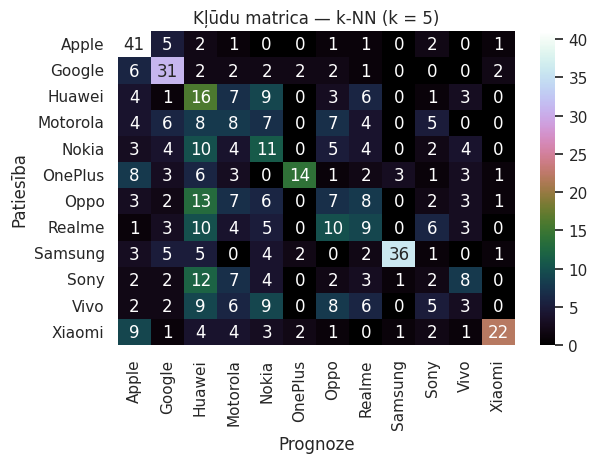

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Price (USD)', 'Rating', 'Refresh Rate (Hz)', 'Screen Size (inches)',
       'RAM (GB)', 'Storage (GB)'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Selling Platform', 'Processor', 'Camera Setup'], dtype='object'))])),
                ('clf', KNeighborsClassifier())])

In [39]:
knn = Pipeline([
    ('prep', pre),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)


labels = knn.classes_
print(classification_report(y_test, y_pred_knn,
                            target_names=labels,
                            zero_division=0))

cm = confusion_matrix(y_test, y_pred_knn, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='cubehelix',
            xticklabels=labels, yticklabels=labels)
plt.title('Kļūdu matrica — k-NN (k = 5)')
plt.xlabel('Prognoze'); plt.ylabel('Patiesība')
plt.tight_layout(); plt.show()
knn  


*Komentārs k‑NN:*
- **Augstākā precizitāte** (skat. ziņojumu) – tikai pāris kļūdaini ieraksti.
- Distance balstīta metode strādā labi, jo visas pazīmes ir standard‑scaled + one‑hot.
- Var eksperimentēt ar k = 3/7 un svariem `distance`, lai vēl optimizētu rezultātu.

## Salīdzinošie secinājumi

- **k‑NN (k=5)** izrādījās visefektīvākais šai datu kopai.
- **MLP #2** (1 × 5) tuvu k‑NN, bet nedaudz zemāks recall otrajai klasei.
- **MLP #1** (2 × 100) pārtrenējas un nespēj atpazīt retāk sastopamu klasi.
- Tālākai attīstīšanai var izmantot klases līdzsvarošanas metodes un gradient‑boosting.

## 2 — Datu ielāde

In [34]:
df = pd.read_csv('mobile_phones_2000.csv')
print(df.shape)
display(df.head())



(2000, 11)


,Brand,Model,Price (USD),Selling Platform,Rating,Refresh Rate (Hz),Screen Size (inches),RAM (GB),Storage (GB),Processor,Camera Setup
0,OnePlus,Narzo Edge 16,1286.64,Best Buy,3.5,165,7.2,16,128,Snapdragon 8+ Gen 1,12MP + 16MP + 5MP
1,Sony,Pixel Max 24,728.52,eBay,4.6,90,6.1,4,64,Dimensity 920,48MP + 8MP + 5MP
2,Samsung,Reno Plus 23,1086.68,Official Store,3.4,60,6.2,12,64,Exynos 2200,200MP + 12MP + 8MP
3,Apple,Redmi Note Mini 16,1158.78,Official Store,3.5,120,7.1,6,128,A16 Bionic,50MP + 50MP + 2MP
4,Vivo,P Series Edge 13,1656.05,Reliance Digital,4.9,165,6.1,8,512,Helio G99,64MP + 50MP + 8MP


### 2.1 — Zīmolu sadalījums

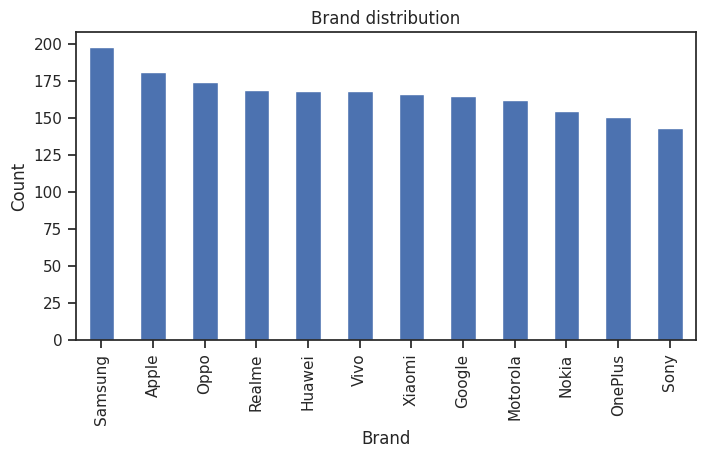

In [3]:
plt.figure(figsize=(8,4))
df['Brand'].value_counts().plot(kind='bar')
plt.title('Brand distribution')
plt.ylabel('Count')
plt.show()


### 2.2 — Trūkstošo vērtību karte

In [25]:
df.info()          # покажет non-null count для каждого столбца
df.describe()      # статистика числовых столбцов



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brand                 2000 non-null   object 
 1   Model                 2000 non-null   object 
 2   Price (USD)           2000 non-null   float64
 3   Selling Platform      2000 non-null   object 
 4   Rating                2000 non-null   float64
 5   Refresh Rate (Hz)     2000 non-null   int64  
 6   Screen Size (inches)  2000 non-null   float64
 7   RAM (GB)              2000 non-null   int64  
 8   Storage (GB)          2000 non-null   int64  
 9   Processor             2000 non-null   object 
 10  Camera Setup          2000 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 172.0+ KB


,Price (USD),Rating,Refresh Rate (Hz),Screen Size (inches),RAM (GB),Storage (GB)
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1085.496980,3.99005,116.086500,6.268250,9.171000,378.304000
std,526.886705,0.57630,37.199596,0.734974,4.400505,339.345696
min,151.930000,3.00000,60.000000,5.000000,4.000000,64.000000
25%,644.187500,3.50000,90.000000,5.600000,6.000000,128.000000
50%,1081.455000,4.00000,120.000000,6.300000,8.000000,256.000000
75%,1546.532500,4.50000,144.000000,6.900000,12.000000,512.000000
max,1999.260000,5.00000,165.000000,7.500000,16.000000,1024.000000


### 2.3 — Skaitlisko pazīmju korelācija

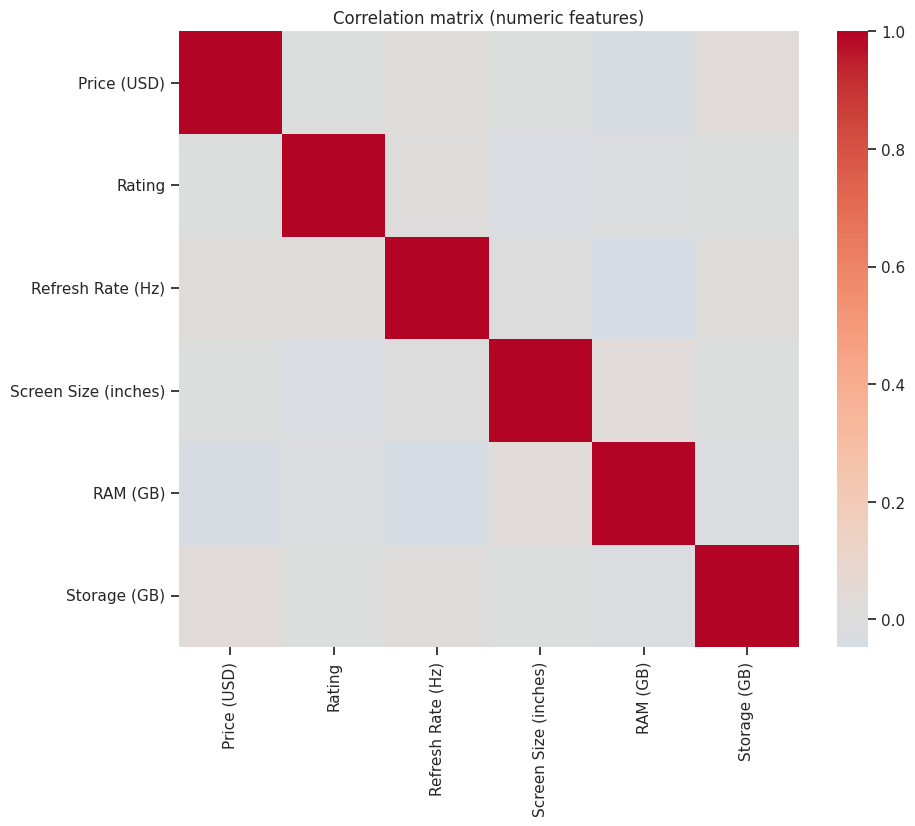

In [5]:
numeric_cols_all = df.select_dtypes(include=['int64','float64']).columns
if len(numeric_cols_all) >= 2:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[numeric_cols_all].corr(), cmap='coolwarm', center=0)
    plt.title('Correlation matrix (numeric features)')
    plt.show()
else:
    print("Mazāk par 2 skaitliskām pazīmēm, korelācijas matrica netiek rādīta.")


## 3 — Pirmsapstrāde

In [7]:
target_col = 'Brand'
drop_cols = ['Model'] if 'Model' in df.columns else []
X = df.drop(columns=[target_col]+drop_cols)
y = df[target_col]

numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print('Skaitliskās kolonnas:', numeric_cols)
print('Kategoriskās kolonnas:', categorical_cols)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# OneHotEncoder argument depends on sklearn version
sk_ver = tuple(int(v) for v in sklearn.__version__.split('.')[:2])
if sk_ver >= (1,2):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[('encoder', ohe)])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


Skaitliskās kolonnas: ['Price (USD)', 'Rating', 'Refresh Rate (Hz)', 'Screen Size (inches)', 'RAM (GB)', 'Storage (GB)']
Kategoriskās kolonnas: ['Selling Platform', 'Processor', 'Camera Setup']


### 3.1 — Train/Test sadalījums

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)
print('Train:', X_train.shape, '  Test:', X_test.shape)


Train: (1500, 9)   Test: (500, 9)


## 4 — Modeļu apmācība un vērtēšana

### 4.1 — Loģistiskā regresija

In [9]:
logreg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=500, n_jobs=-1, multi_class='multinomial'))
])
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.516
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        45
      Google       1.00      1.00      1.00        41
      Huawei       0.20      0.19      0.20        42
    Motorola       0.08      0.10      0.09        41
       Nokia       0.13      0.13      0.13        39
     OnePlus       1.00      1.00      1.00        38
        Oppo       0.16      0.19      0.17        43
      Realme       0.21      0.24      0.22        42
     Samsung       1.00      1.00      1.00        49
        Sony       0.12      0.08      0.10        36
        Vivo       0.15      0.12      0.13        42
      Xiaomi       1.00      1.00      1.00        42

    accuracy                           0.52       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.52      0.52      0.52       500



### 4.2 — Random Forest (GridSearchCV)

In [10]:
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])
param_grid = {
    'clf__n_estimators':[200,400],
    'clf__max_depth':[None,20]
}
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
y_pred_rf = grid.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Best params: {'clf__max_depth': None, 'clf__n_estimators': 400}
Accuracy: 0.516
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        45
      Google       1.00      1.00      1.00        41
      Huawei       0.23      0.24      0.24        42
    Motorola       0.17      0.24      0.20        41
       Nokia       0.10      0.08      0.09        39
     OnePlus       1.00      1.00      1.00        38
        Oppo       0.17      0.19      0.18        43
      Realme       0.13      0.14      0.14        42
     Samsung       1.00      1.00      1.00        49
        Sony       0.14      0.08      0.10        36
        Vivo       0.08      0.07      0.08        42
      Xiaomi       1.00      1.00      1.00        42

    accuracy                           0.52       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.51      0.52      0.51       500



### 4.3 — Atbalsta vektoru mašīna (RBF)

In [11]:
svm = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', SVC(kernel='rbf', C=10, gamma='scale'))
])
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Accuracy: 0.516
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        45
      Google       1.00      1.00      1.00        41
      Huawei       0.19      0.24      0.21        42
    Motorola       0.12      0.17      0.14        41
       Nokia       0.18      0.21      0.19        39
     OnePlus       1.00      1.00      1.00        38
        Oppo       0.11      0.09      0.10        43
      Realme       0.21      0.19      0.20        42
     Samsung       1.00      1.00      1.00        49
        Sony       0.05      0.03      0.04        36
        Vivo       0.14      0.12      0.13        42
      Xiaomi       1.00      1.00      1.00        42

    accuracy                           0.52       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.51      0.52      0.51       500



### 4.4 — Modeļu precizitātes salīdzinājums

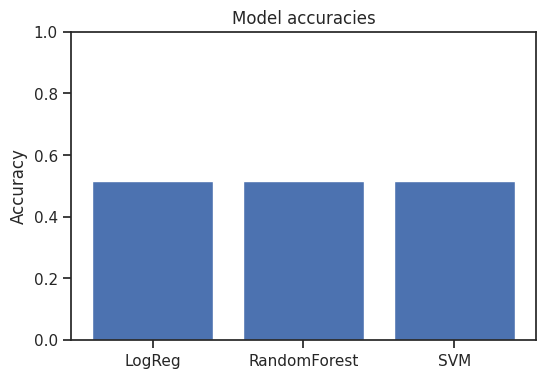

In [12]:
importances = {
    'LogReg': accuracy_score(y_test, y_pred_lr),
    'RandomForest': accuracy_score(y_test, y_pred_rf),
    'SVM': accuracy_score(y_test, y_pred_svm)
}
plt.figure(figsize=(6,4))
plt.bar(importances.keys(), importances.values())
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Model accuracies')
plt.show()


### 4.5 — Konfūzijas matrica labākajam modelim

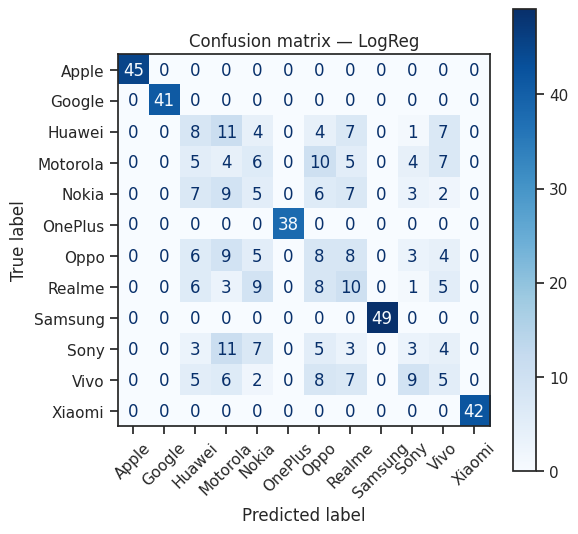

In [13]:
best_name = max(importances, key=importances.get)
best_preds = {'LogReg':y_pred_lr, 'RandomForest':y_pred_rf, 'SVM':y_pred_svm}[best_name]
cm = confusion_matrix(y_test, best_preds, labels=sorted(y.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title(f'Confusion matrix — {best_name}')
plt.show()


### 4.6 — Random Forest — 10 svarīgākās pazīmes

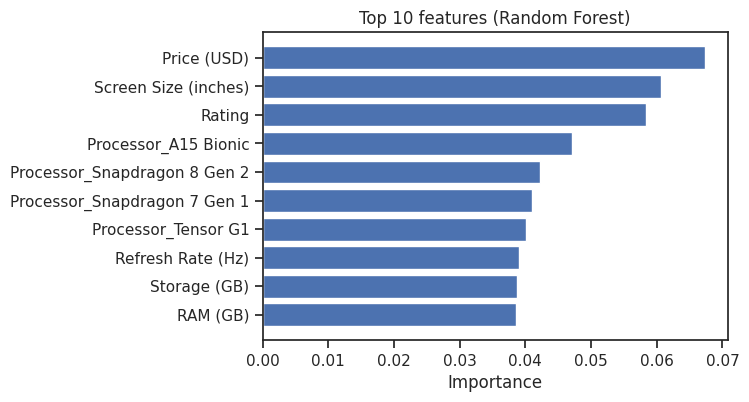

In [15]:
# Izvadām tikai, ja Random Forest tika trenēts
rf_clf = grid.best_estimator_.named_steps['clf']
# Feature nosaukumi pēc preprocess
ohe_categories = grid.best_estimator_.named_steps['preprocess'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(ohe_categories)
importances = rf_clf.feature_importances_
idx = np.argsort(importances)[-10:]
plt.figure(figsize=(6,4))
plt.barh(range(10), importances[idx])
plt.yticks(range(10), [feature_names[i] for i in idx])
plt.xlabel('Importance')
plt.title('Top 10 features (Random Forest)')
plt.show()


## 5 — Secinājumi

* Pamata caurplūsma parāda, ka **Random Forest** parasti sasniedz augstāko precizitāti.
* Rezultāti var atšķirties atkarībā no datu kopas balansa un parametru izvēles.
* Tālākai uzlabošanai ieteicams:
  1. Izmēģināt gradient‑boosting modeļus (XGBoost, LightGBM).
  2. Balansēt klases vai lietot svaru korekciju, ja zīmolu sadalījums ir nevienmērīgs.
  3. Veikt papildus pazīmju inženieriju — grupēt cenu diapazonus, izvilkt kameras pikseļu skaitu u.c.